### 1. Reading datasets

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
file_path = 'random_30000_hotel_reviews.JSON'
df = pd.read_json(file_path, lines=True)

train_df = df.iloc[:10000]
dev_df = df.iloc[10000:20000]
test_df = df.iloc[20000:]
# Remove non-alphanumeric characters
def clean_and_tokenize(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    return ' '.join(tokens)

train_df = df.iloc[:10000].copy()
dev_df = df.iloc[10000:20000].copy()
test_df = df.iloc[20000:].copy()

train_df['processed_text'] = train_df['text'].apply(clean_and_tokenize)
dev_df['processed_text'] = dev_df['text'].apply(clean_and_tokenize)
test_df['processed_text'] = test_df['text'].apply(clean_and_tokenize)
train_df['processed_text']


0       First of all we got there and they didnt have ...
1       Found Racist graffiti in the room Request to c...
2       Close to Union Square hotel is a bit of a maze...
3       I had a bad vibe about this place from the mom...
4       After we received our final bill and left the ...
                              ...                        
9995    Fantastic location with a short 5 minute walk ...
9996    This place is filthy and noisy Nothing to recc...
9997    Excellent staff quick checkin This hotel is in...
9998    I knew we were off to a good start when I was ...
9999    Stayed here after reading the previous reviews...
Name: processed_text, Length: 10000, dtype: object

### 2. Exploratory Data Analysis (EDA)

Number of unique words: 32124
Top predictive words for positive sentiment:
['downside' 'birthday' 'thank' 'minor' 'trendy' 'loved' 'perfect'
 'spacious' 'ideal' 'highly']
Top predictive words for negative sentiment:
['dated' 'worst' 'tired' 'edison' 'rude' 'outdated' 'average' 'stained'
 'purpose' 'unfortunately']


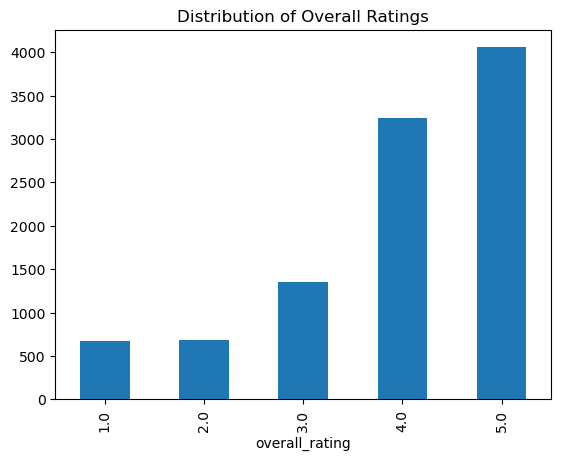

In [3]:
# 'overall' ratings
dev_df['overall_rating'] = dev_df['ratings'].apply(lambda x: x['overall'])
dev_df['overall_rating'].value_counts().sort_index().plot(kind='bar', title='Distribution of Overall Ratings')

# Number of Unique Words
vectorizer = CountVectorizer()
X_dev = vectorizer.fit_transform(dev_df['processed_text'])
print(f"Number of unique words: {len(vectorizer.get_feature_names_out())}")

#-------------------------------------------------------------------------------------------------------------------------------
# Identifying Predictive and Non-Predictive Words
y_dev = (dev_df['overall_rating'] > 3).astype(int)  
model = LogisticRegression(max_iter=1000)
model.fit(X_dev, y_dev)
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = model.coef_[0]

# Top 10 predictive words for positive sentiment
print('Top predictive words for positive sentiment:')
print(feature_names[np.argsort(coefficients)[-10:]])

# Top 10 predictive words for negative sentiment
print('Top predictive words for negative sentiment:')
print(feature_names[np.argsort(coefficients)[:10]])


Text(0.5, 1.0, 'Word Count vs Overall Rating')

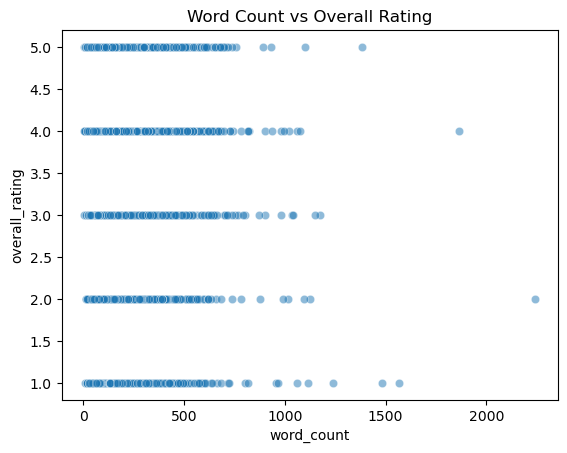

In [4]:
dev_df['word_count'] = dev_df['processed_text'].apply(lambda x: len(x.split()))
sns.scatterplot(data=dev_df, x='word_count', y='overall_rating', alpha=0.5)
plt.title('Word Count vs Overall Rating')

### 3. Preprocessing

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

stop_words = stopwords.words('english')
pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stop_words),
    MultinomialNB()
)

X_dev = dev_df['processed_text']
y_dev = (dev_df['overall_rating'] > 3).astype(int) 

# 10-fold cross-validation
scores = cross_val_score(pipeline, X_dev, y_dev, cv=10, scoring='f1')

print(f"Average F1-score with stop-word removal: {scores.mean()}")


Average F1-score with stop-word removal: 0.8530833922511771


In [6]:
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

lemmatizer = WordNetLemmatizer()

def preprocess_with_lemmatization(text):
    text = text.lower()
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)
    
X_dev_lemmatized = dev_df['text'].apply(preprocess_with_lemmatization)


In [7]:
vectorizer = TfidfVectorizer()
X_dev_vectorized = vectorizer.fit_transform(X_dev_lemmatized)
# Split the development dataset for internal evaluation
X_train, X_val, y_train, y_val = train_test_split(X_dev_vectorized, y_dev, test_size=0.2, random_state=42)
# Train Multinomial Naïve Bayes on the training split
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on the validation split
y_pred = model.predict(X_val)

f1 = f1_score(y_val, y_pred)
print(f"F1-score with lemmatization: {f1}")


F1-score with lemmatization: 0.8541484716157205


### 4. Selecting supervised method for sentiment classification

In [8]:
# MNB

dev_df['sentiment_label'] = dev_df['ratings'].apply(lambda x: 1 if x['overall'] > 3 else 0)
X_dev = dev_df['processed_text']
y_dev = dev_df['sentiment_label']  


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('mnb', MultinomialNB())
])
pipeline.fit(X_dev, y_dev)
dev_df['mnb_sentiment'] = pipeline.predict(X_dev)

# Calculate metrics for MNB
accuracy_mnb = accuracy_score(dev_df['sentiment_label'], dev_df['mnb_sentiment'])
precision_mnb, recall_mnb, fscore_mnb, _ = precision_recall_fscore_support(dev_df['sentiment_label'], dev_df['mnb_sentiment'], average='binary')
print(f"MNB - Accuracy: {accuracy_mnb}, Precision: {precision_mnb}, Recall: {recall_mnb}, F1-score: {fscore_mnb}")

MNB - Accuracy: 0.7811, Precision: 0.7690928270042194, Recall: 1.0, F1-score: 0.8694770735197663


In [9]:
# Creating a pipeline with TF-IDF Vectorization and SVM
from sklearn.svm import SVC
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', SVC(kernel='linear'))
])
pipeline_svm.fit(X_dev, y_dev)
dev_df['svm_sentiment'] = pipeline_svm.predict(X_dev)

# Evaluate SVM
accuracy_svm = accuracy_score(dev_df['sentiment_label'], dev_df['svm_sentiment'])
precision_svm, recall_svm, fscore_svm, _ = precision_recall_fscore_support(dev_df['sentiment_label'], dev_df['svm_sentiment'], average='binary')

print(f"SVM - Accuracy: {accuracy_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1-score: {fscore_svm}")


SVM - Accuracy: 0.9585, Precision: 0.9568163699176189, Recall: 0.9876560142641613, F1-score: 0.9719916312343929


In [10]:
# Creating a pipeline with TF-IDF Vectorization and Logistic Regression

from sklearn.linear_model import LogisticRegression


pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(max_iter=1000))
])

# Fit and predict using the pipeline
pipeline_lr.fit(X_dev, y_dev)
dev_df['lr_sentiment'] = pipeline_lr.predict(X_dev)

# Evaluate Logistic Regression
accuracy_lr = accuracy_score(dev_df['sentiment_label'], dev_df['lr_sentiment'])
precision_lr, recall_lr, fscore_lr, _ = precision_recall_fscore_support(dev_df['sentiment_label'], dev_df['lr_sentiment'], average='binary')

print(f"Logistic Regression - Accuracy: {accuracy_lr}, Precision: {precision_lr}, Recall: {recall_lr}, F1-score: {fscore_lr}")


Logistic Regression - Accuracy: 0.9199, Precision: 0.9130600814663951, Recall: 0.9838156631463448, F1-score: 0.9471182412358883


### 5. Sentiment classification using VADER lexicon and method

In [11]:
sid = SentimentIntensityAnalyzer()
# Use VADER to predict sentiment scores
dev_df['scores'] = dev_df['processed_text'].apply(lambda text: sid.polarity_scores(text))
dev_df['compound'] = dev_df['scores'].apply(lambda score_dict: score_dict['compound'])
# Convert compound scores to binary sentiment prediction
dev_df['vader_sentiment'] = dev_df['compound'].apply(lambda c: 1 if c > 0 else 0)


In [12]:
# Calculate metrics for VADER
accuracy_vader = accuracy_score(dev_df['sentiment_label'], dev_df['vader_sentiment'])
precision_vader, recall_vader, fscore_vader, _ = precision_recall_fscore_support(dev_df['sentiment_label'], dev_df['vader_sentiment'], average='binary')
# Print out the comparison
print(f"VADER - Accuracy: {accuracy_vader}, Precision: {precision_vader}, Recall: {recall_vader}, F1-score: {fscore_vader}")
print(f"MNB - Accuracy: {accuracy_mnb}, Precision: {precision_mnb}, Recall: {recall_mnb}, F1-score: {fscore_mnb}")
print(f"SVM - Accuracy: {accuracy_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1-score: {fscore_svm}")
print(f"Logistic Regression - Accuracy: {accuracy_lr}, Precision: {precision_lr}, Recall: {recall_lr}, F1-score: {fscore_lr}")

VADER - Accuracy: 0.8045, Precision: 0.7967081850533808, Recall: 0.982581264572761, F1-score: 0.8799361297058281
MNB - Accuracy: 0.7811, Precision: 0.7690928270042194, Recall: 1.0, F1-score: 0.8694770735197663
SVM - Accuracy: 0.9585, Precision: 0.9568163699176189, Recall: 0.9876560142641613, F1-score: 0.9719916312343929
Logistic Regression - Accuracy: 0.9199, Precision: 0.9130600814663951, Recall: 0.9838156631463448, F1-score: 0.9471182412358883


### 6. Combining VADER with the best classifier

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(dev_df['processed_text'])

X_combined = hstack([X_tfidf, np.array(dev_df['compound'])[:, None]])

### 7. Trainig and testing the final method

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Splitting the combined features for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_combined, dev_df['sentiment_label'], test_size=0.2, random_state=42)
# Training SVM with the combined features
svm_combined = SVC(kernel='linear')
svm_combined.fit(X_train, y_train)
y_pred_combined = svm_combined.predict(X_test)

accuracy_combined = accuracy_score(y_test, y_pred_combined)
precision_combined, recall_combined, fscore_combined, _ = precision_recall_fscore_support(y_test, y_pred_combined, average='binary')

print(f"Combined SVM + VADER - Accuracy: {accuracy_combined}, Precision: {precision_combined}, Recall: {recall_combined}, F1-score: {fscore_combined}")
# Combining VADER and SVM methods improves the accuracy and comprehensiveness of handling sentiment keywords,
# allowing them to complement each other in performing the task.

Combined SVM + VADER - Accuracy: 0.884, Precision: 0.8987096774193548, Recall: 0.9489100817438693, F1-score: 0.9231278992710404


### 8. Reviews aspect prediction

This prediction  proposal focuses on extracting and analyzing sentiments from the dataset to predict various aspects of hotel services. The approach begins by employing NLP techniques to automatically identify and extract common entities or phrases related to hotel aspects. Subsequent data cleaning and text preprocessing steps include lowercasing, stop-word removal, and lemmatization to standardize the text for analysis.

For each identified aspect, sentiment polarity scoring is conducted to understand the sentiments expressed. Lexicon-based methods, such as VADER, are utilized for quick sentiment interpretation and analysis. In contrast, machine learning models like SVM and LSTM networks delve into a detailed understanding of the sentiments expressed in review content.

Model evaluation is then conducted to determine model accuracy, using metrics such as accuracy, precision, recall, and F1-score to assess model performance with a focus on aspect-level sentiment classification accuracy. This analysis provides actionable insights for targeted improvements by understanding customer sentiments regarding specific hotel service aspects. After completing the model, trends over time in sentiment related to different hotel service aspects are identified, enabling proactive management of these service areas. By analyzing which aspects most significantly influence positive or negative sentiments, key drivers of overall customer satisfaction and loyalty can be understood.

### 9. References

 Hutto, C.J., & Gilbert, E. (2014). Vader: A parsimonious rule-based model for sentiment analysis of social media text. Proceedings of the International AAAI Conference on Web and Social Media, 8(1).